In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns
from subprocess import check_output

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
#loading the dataset.......(Train)
df = pd.read_csv("df.csv")
print(df.shape)
df = df.drop(["Unnamed: 0"], axis = 1)
df.columns.values[0] = 'label'
df.head()

(10000, 786)


,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


### Splitting into train/test

In [4]:
train, test = train_test_split(df, test_size=0.2)

In [5]:
x_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
x_test = test.iloc[:,1:].values.astype('float32')

### Preview the images

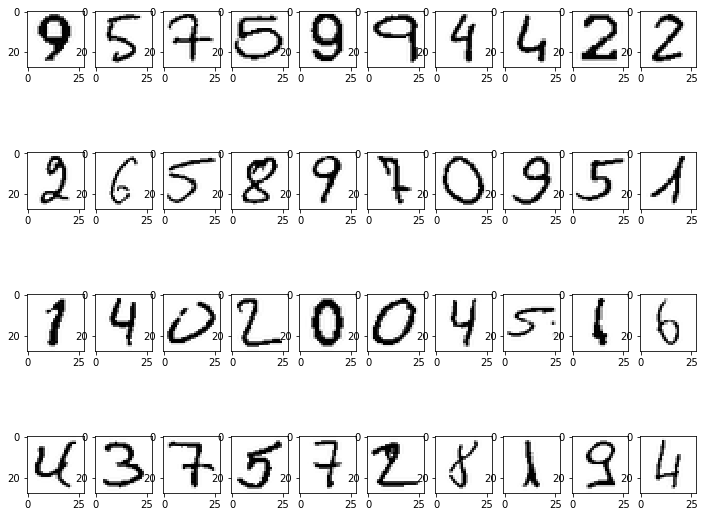

In [25]:
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest', cmap="gray")
plt.show()

### Normalise data

In [7]:
x_train = x_train/255.0
x_test = x_test/255.0

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8000, 784)
8000 train samples
2000 test samples


### Reshaping

In [9]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

### Model

In [10]:
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

In [11]:
# convert class vectors to binary class matrices One Hot Encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [26]:
# model.summary()

In [14]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

Epoch 1/20
112/112 [==============================] - 39s 347ms/step - loss: 1.3286 - acc: 0.5661 - val_loss: 2.2077 - val_acc: 0.4875
Epoch 2/20
112/112 [==============================] - 42s 378ms/step - loss: 0.4444 - acc: 0.8610 - val_loss: 0.1368 - val_acc: 0.9650
Epoch 3/20
112/112 [==============================] - 37s 331ms/step - loss: 0.2846 - acc: 0.9116 - val_loss: 0.1591 - val_acc: 0.9575
Epoch 4/20
112/112 [==============================] - 42s 373ms/step - loss: 0.2198 - acc: 0.9364 - val_loss: 0.1113 - val_acc: 0.9700
Epoch 5/20
112/112 [==============================] - 47s 418ms/step - loss: 0.1878 - acc: 0.9455 - val_loss: 0.1236 - val_acc: 0.9675
Epoch 6/20
112/112 [==============================] - 35s 316ms/step - loss: 0.1568 - acc: 0.9544 - val_loss: 0.0977 - val_acc: 0.9750
Epoch 7/20
112/112 [==============================] - 35s 315ms/step - loss: 0.1461 - acc: 0.9601 - val_loss: 0.0749 - val_acc: 0.9825
Epoch 8/20
112/112 [==============================] - 3

In [15]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.042480, final accuracy: 0.987500


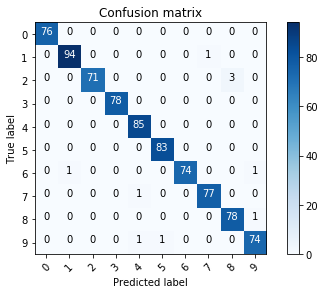

In [16]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


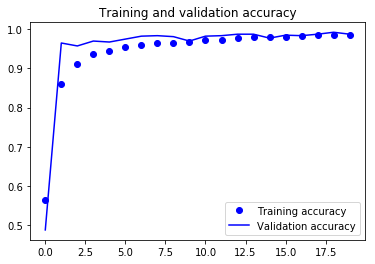

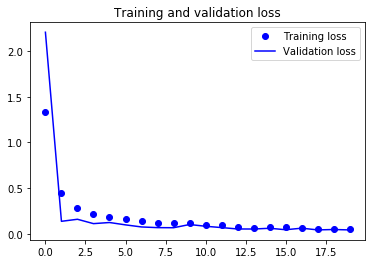

In [17]:
print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Classification report

In [24]:
# score = model.evaluate(X_test[:,1:], X_test[:,0], verbose=1)
# print('Test accuracy:', score[1])

In [18]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
y_true = test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [19]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.99      0.99      0.99       212
    Class 1       0.98      0.96      0.97       186
    Class 2       1.00      0.99      0.99       229
    Class 3       1.00      0.98      0.99       205
    Class 4       0.98      0.99      0.99       176
    Class 5       1.00      0.99      0.99       208
    Class 6       0.99      0.99      0.99       204
    Class 7       0.98      0.99      0.98       190
    Class 8       0.96      0.99      0.98       194
    Class 9       0.97      0.96      0.97       196

avg / total       0.98      0.98      0.98      2000

